# Building and training a simple neural network in JAX

JAX is a numerical computing library.

Differences to torch:

1. Need to explicitly 'split' the random number key, as opposed to re-using the random number generator. The key is usually the first parameter for any random-generating function (rather than in torch, where it's a later parameter, often passed as a named parameter 'generator')
2. 'size' -> 'shape'
3. 'dim' -> 'axis'

There are 2 ways to vectorize over the batch:

1. Explicitly include the extra batch dimension as the first dimension in inputs, have all operations understand and deal with that dimension, and set batch_size = 1 for single examples.
2. Write the matrix operation to act on a single set of inputs, then use jax.vmap to vectorize over the batch dimension.

Below applies the explicit batch dimension, for closer comparison to the torch example. When jitted, the performance seems to be similar between the two implementations.

### Globals

In [1]:
import math
import time

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

### Data loading

The dataloader needs to supply a numpy or jax array, not a torch tensor.

Shape of inputs (aka 'X') is (64, 28, 28)
Shape of targets (aka 'y') is (64,)


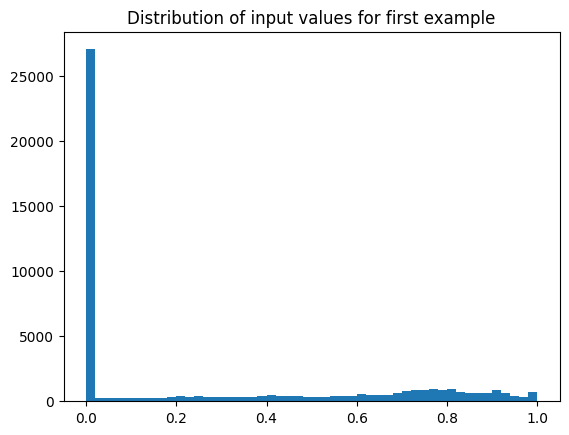

In [2]:
import numpy as np
from jax.tree_util import tree_map
from torch.utils import data
from torchvision import datasets


def _flatten_and_cast(pic):
    return np.array(pic, dtype=jnp.float32) / 255


def _numpy_collate(batch):
  return tree_map(jnp.asarray, data.default_collate(batch))


def get_dataloader(batch_size: int, train: bool):
    mnist_dataset = datasets.FashionMNIST(
        "data",
        train=train,
        download=True,
        transform=_flatten_and_cast
    )

    return data.DataLoader(
        mnist_dataset,
        batch_size=batch_size,
        collate_fn=_numpy_collate,
    )


training_dataloader = get_dataloader(batch_size=64, train=True)
testing_dataloader = get_dataloader(batch_size=64, train=False)

for inputs, targets in testing_dataloader:
    print(f"Shape of inputs (aka 'X') is {inputs.shape}")
    print(f"Shape of targets (aka 'y') is {targets.shape}")
    break

fig, axs = plt.subplots()
axs.hist(inputs.ravel(), bins=50)
axs.set_title("Distribution of input values for first example")
plt.show()

### Building the network

#### Flattening

In [3]:
def flatten_layer(inputs):
    """
    inputs: shape (batch_size, ...)
    ie the inputs can have any number of dimensions >= 2, and the
    output will flatten this to (batch_size, ?)
    """
    batch_size = inputs.shape[0]
    return jnp.reshape(inputs, shape=(batch_size, -1))

In [4]:
# Code to test / demonstrate the flatten_layer
sample_key = jax.random.PRNGKey(12345678)
sample_batch_size = 24
sample_inputs = jax.random.normal(sample_key, shape=(sample_batch_size, 5, 12, 28))

result = flatten_layer(sample_inputs)
print(f"{sample_inputs.shape=}, batched {result.shape=}")
expected_shape = (sample_batch_size, math.prod(sample_inputs.shape[1:]))
assert result.shape == expected_shape
assert jnp.array_equal(result[0, :28], sample_inputs[0, 0, 0, :])

sample_inputs.shape=(24, 5, 12, 28), batched result.shape=(24, 1680)


#### Linear Layer

In [5]:
def linear_layer(inputs, params):
    """
    inputs: dimensions (*, dim_in)
    params: tuple ((dim_in, dim_out), (1, dim_out))
    outputs: dimensions (*, dim_out)

    ie the inputs can have any shape as long as the last dimension
    is dim_in. Then the output will be the same shape, finishing with dim_out.

    In a simple network, the input will be (batch_size, dim_in), giving
    output (batch_size, dim_out).
    """
    w, b = params
    return inputs @ w + b


def random_linear_params(key, dim_in: int, dim_out: int, scale: float | None = None):
    """
    Generate random parameters from a uniform distribution for a linear_layer
    w is the 'slope' and b is the 'intercept'
    The scale is chosen to match the default in torch for a LinearLayer.
    """
    w_key, b_key = jax.random.split(key)
    if scale is None:
        scale = dim_in ** -0.5
        
    w = jax.random.uniform(
        w_key,
        shape=(dim_in, dim_out),
        minval=-scale,
        maxval=scale,
    )
    b = jax.random.uniform(
        b_key,
        shape=(1, dim_out),
        minval=-scale,
        maxval=scale,
    )

    return w, b

In [6]:
# Code to test / demonstrate the linear_layer
sample_batch_size = 100
dim_in = 3
dim_out = 4
sample_key = jax.random.PRNGKey(12345678)
sample_key, input_key, params_key = jax.random.split(sample_key, 3)
sample_inputs = jax.random.normal(input_key, shape=(sample_batch_size, 2, 3, dim_in))
sample_params = random_linear_params(params_key, dim_in, dim_out)

result = linear_layer(sample_inputs, sample_params)
assert result.shape == (sample_batch_size, 2, 3, dim_out)
print(f"{sample_inputs.shape=}")
print(f"Sample params shapes = {[p.shape for p in sample_params]}")
print(f"{result.shape=}")

sample_inputs.shape=(100, 2, 3, 3)
Sample params shapes = [(3, 4), (1, 4)]
result.shape=(100, 2, 3, 4)


#### Soft max

In [7]:
def log_softmax_layer(inputs):
    """
    inputs: shape (*, dim_in)
    returns: shape (*, dim_in)

    For a simple example, inputs = (batch_size, dim_in)
    and returns = (batch_size, dim_in)
    """
    return inputs - jax.scipy.special.logsumexp(inputs, axis=1, keepdims=True)

In [8]:
sample_batch_size = 100
dim_in = 23
sample_key = jax.random.PRNGKey(12345678)
sample_inputs = jax.random.normal(sample_key, shape=(sample_batch_size, dim_in))

result = log_softmax_layer(sample_inputs)
assert result.shape == sample_inputs.shape
sums = jnp.sum(jnp.exp(result), axis=1)
assert sums.shape == (sample_batch_size, )
assert jnp.isclose(sums, 1.).all()

#### Combining the layers

In [9]:
def relu(x):
    return jnp.maximum(0, x)


def predict(params, inputs):
    x = inputs
    x = flatten_layer(x)
    x = linear_layer(x, params["linear_1"])
    x = relu(x)
    x = linear_layer(x, params["linear_2"])
    x = relu(x)
    x = linear_layer(x, params["linear_3"])
    x = log_softmax_layer(x)
    return x

In [10]:
# Testing / demonstrating the model
sample_batch_size = 100
image_shape = (1, 28, 28)
dim_in = math.prod(image_shape)
dim_hidden = 24
dim_out = 25

sample_key = jax.random.PRNGKey(12345678)
sample_key, *params_keys = jax.random.split(sample_key, 4)
sample_params = {
    "linear_1": random_linear_params(params_keys[0], dim_in, dim_hidden),
    "linear_2": random_linear_params(params_keys[1], dim_hidden, dim_hidden),
    "linear_3": random_linear_params(params_keys[2], dim_hidden, dim_out),
}
sample_key, inputs_key = jax.random.split(sample_key)
sample_inputs = jax.random.normal(inputs_key, shape=(sample_batch_size, image_shape[0], image_shape[1], image_shape[2]))
result = predict(sample_params, sample_inputs)
print(f"{sample_inputs.shape=}, batched {result.shape=}")
assert result.shape == (sample_batch_size, dim_out)

sample_inputs.shape=(100, 1, 28, 28), batched result.shape=(100, 25)


### Training the network

In [11]:
def loss_fn(logits, targets):
    """
    logits: shape (batch_size, dim_out)
    targets: shape (batch_size, 1), values in range(dim_out)

    ie logits is encoding the probability of each category.
    """
    batch_size = logits.shape[0]
    return -jnp.mean(logits[jnp.arange(batch_size), targets])


def calc_loss(params, inputs, targets):
    predictions = predict(params, inputs)
    return loss_fn(predictions, targets)


@jax.jit
def update(params, inputs, targets, step_size):
    grads = jax.grad(calc_loss)(params, inputs, targets)
    return {
        key: [p - step_size * d_p for p, d_p in zip(value, grads[key])]
        for key, value in params.items()
    }

In [12]:
# Testing / demonstrating the model
sample_batch_size = 99
image_shape = (1, 28, 28)
dim_in = math.prod(image_shape)
dim_hidden = 24
dim_out = 25

sample_key = jax.random.PRNGKey(12345678)

sample_key, *params_keys = jax.random.split(sample_key, 4)
sample_params = {
    "linear_1": random_linear_params(params_keys[0], dim_in, dim_hidden),
    "linear_2": random_linear_params(params_keys[1], dim_hidden, dim_hidden),
    "linear_3": random_linear_params(params_keys[2], dim_hidden, dim_out),
}

sample_key, inputs_key = jax.random.split(sample_key)
sample_inputs = jax.random.normal(inputs_key, shape=(sample_batch_size, image_shape[0], image_shape[1], image_shape[2]))

sample_key, targets_key = jax.random.split(sample_key)
sample_targets = jax.random.randint(targets_key, minval=0, maxval=dim_out, shape=(sample_batch_size, ))

result = calc_loss(sample_params, sample_inputs, sample_targets)
assert result.shape == ()

In [13]:
def test(dataloader, params, predictor, loss_fn):
    all_targets = []
    all_predictions = []
    all_losses = []
    for inputs, targets in dataloader:
        predictions = predictor(params, inputs)
        loss = loss_fn(predictions, targets)
        all_predictions.append(predictions.argmax(axis=1))
        all_targets.append(targets)
        all_losses.append(loss)

    all_predictions = jnp.concatenate(all_predictions)
    all_targets = jnp.concatenate(all_targets)

    return all_targets, all_predictions, all_losses

In [14]:
key = jax.random.PRNGKey(5)

dim_in = 1 * 28 * 28
dim_hidden = 512
dim_out = 10
key, *params_keys = jax.random.split(key, 4)
params = {
    "linear_1": random_linear_params(params_keys[0], dim_in, dim_hidden),
    "linear_2": random_linear_params(params_keys[1], dim_hidden, dim_hidden),
    "linear_3": random_linear_params(params_keys[2], dim_hidden, dim_out),
}
num_params = sum(math.prod(p.shape) for ps in params.values() for p in ps)
print(f"Total number of parameters = {num_params:,}")
initial_params = {key: [p.clone() for p in ps] for key, ps in params.items()}

step_size = 1e-3
epochs = 5

print("")
for t in range(epochs):
    print(f"Epoch {t + 1}\n-----------------------")
    epoch_start = time.monotonic()
    total_length = len(training_dataloader.dataset)
    count = 0
    for batch, (inputs, targets) in enumerate(training_dataloader):
        if batch % 100 == 0 or count >= total_length:
            predictions = predict(params, inputs)
            loss = loss_fn(predictions, targets)
            print(f"loss: {loss.item():>7f}  [{count:>5d} / {total_length:>5d}]")

        params = update(params, inputs, targets, step_size)
        count += len(inputs)

    epoch_end = time.monotonic()
    test_targets, test_preds, test_losses = test(testing_dataloader, params, predict, loss_fn)
    correct = (jnp.equal(test_preds, test_targets).sum() / len(test_preds)).item()
    losses = jnp.array(test_losses)
    print(f"Test error: accuracy = {100 * correct:>0.1f}%, average loss = {losses.mean().item():>8f}")
    print(f"Epoch elapsed time = {epoch_end - epoch_start:.1f} seconds")
    print("")

Total number of parameters = 669,706

Epoch 1
-----------------------
loss: 2.317740  [    0 / 60000]
loss: 2.301610  [ 6400 / 60000]
loss: 2.278785  [12800 / 60000]
loss: 2.265497  [19200 / 60000]
loss: 2.258972  [25600 / 60000]
loss: 2.235002  [32000 / 60000]
loss: 2.240322  [38400 / 60000]
loss: 2.214226  [44800 / 60000]
loss: 2.204908  [51200 / 60000]
loss: 2.164660  [57600 / 60000]
Test error: accuracy = 37.9%, average loss = 2.167651
Epoch elapsed time = 1.9 seconds

Epoch 2
-----------------------
loss: 2.188108  [    0 / 60000]
loss: 2.172646  [ 6400 / 60000]
loss: 2.113899  [12800 / 60000]
loss: 2.117097  [19200 / 60000]
loss: 2.081815  [25600 / 60000]
loss: 2.033848  [32000 / 60000]
loss: 2.053538  [38400 / 60000]
loss: 1.989005  [44800 / 60000]
loss: 1.982299  [51200 / 60000]
loss: 1.895633  [57600 / 60000]
Test error: accuracy = 51.7%, average loss = 1.906280
Epoch elapsed time = 1.3 seconds

Epoch 3
-----------------------
loss: 1.950914  [    0 / 60000]
loss: 1.915000  [ 

## Using the network

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

test_targets, test_preds, test_losses = test(testing_dataloader, params, predict, loss_fn)

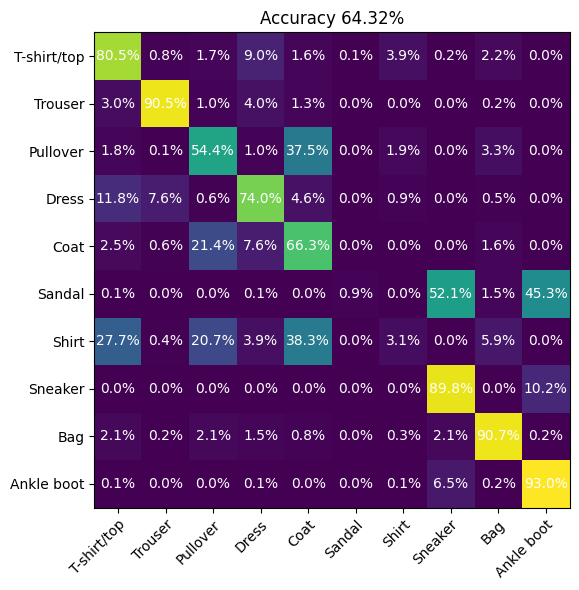

In [16]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_targets, test_preds)
confusion = confusion / confusion.sum(axis=1)

accuracy = jnp.equal(test_preds, test_targets).sum() / len(test_preds)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(confusion)
ax.set_xticks(jnp.arange(len(classes)), labels=classes)
ax.set_yticks(jnp.arange(len(classes)), labels=classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, f"{confusion[i, j]:.1%}",
                       ha="center", va="center", color="w")

ax.set_title(f"Accuracy {accuracy:.2%}")
fig.tight_layout()

plt.show()

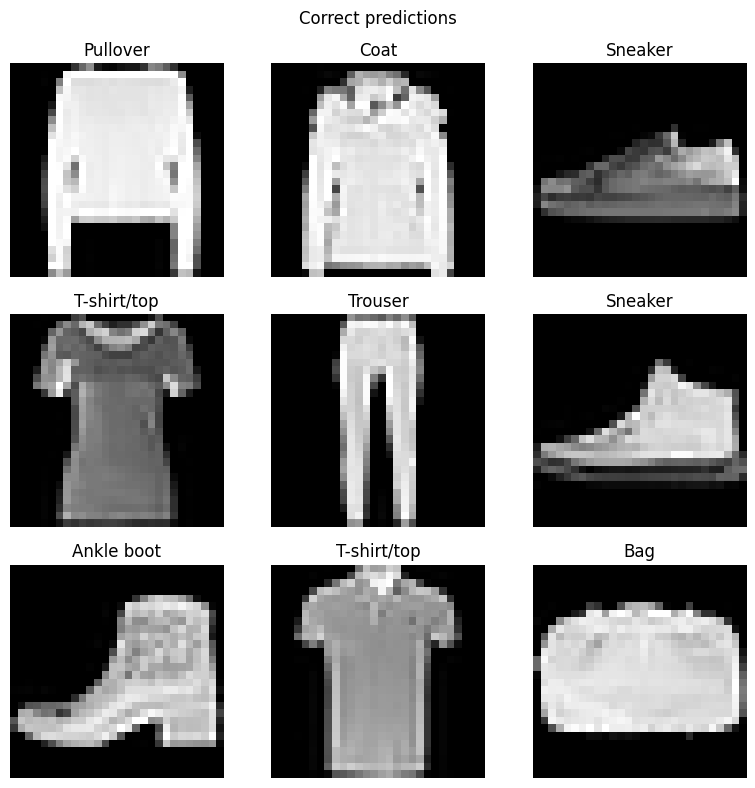

In [17]:
correct = jnp.argwhere(jnp.equal(test_targets, test_preds)).ravel()
fig_key = jax.random.PRNGKey(12345678)
fig_key, *subkeys = jax.random.split(fig_key, 10)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = jax.random.randint(subkeys[i - 1], minval=0, maxval=len(correct), shape=(1,))
    img, label = testing_dataloader.dataset[correct[sample_idx].item()]
    fig.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
fig.suptitle("Correct predictions")
fig.tight_layout()
plt.show()

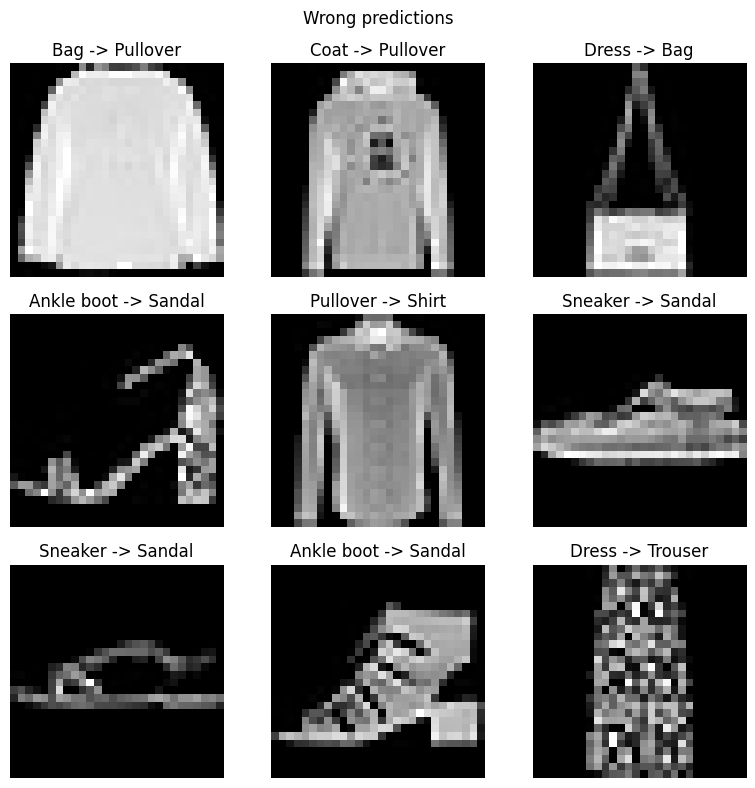

In [18]:
incorrect = jnp.argwhere(~jnp.equal(test_targets, test_preds)).ravel()
fig_key = jax.random.PRNGKey(12345678)
fig_key, *subkeys = jax.random.split(fig_key, 10)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = jax.random.randint(subkeys[i - 1], minval=0, maxval=len(incorrect), shape=(1,))
    img, label = testing_dataloader.dataset[incorrect[sample_idx].item()]
    predicted = classes[test_preds[incorrect[sample_idx]].item()]
    fig.add_subplot(rows, cols, i)
    plt.title(f"{predicted} -> {classes[label]}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

fig.suptitle("Wrong predictions")
fig.tight_layout()
plt.show()